### Reanalysis 
To further this study I wanted to expand on 

In [525]:
# Calculate Majority Group in tracts
threshold = 60.0
for index, row in tracts2010.iterrows():
    # Check the condition for each row using 'index' to access specific values
    if row['pctWhite'] >= 66.666:  # Check if 'pctWhite' is greater than or equal to 60.0
        tracts2010.loc[index, 'Segregated'] = 'White'  # Assign 'White' to 'majorGroup'
    elif 33.3333 < row['pctWhite'] <= 66.666:  
        tracts2010.loc[index, 'Segregated'] = 'Mixed'
    else: 
        tracts2010.loc[index, 'Segregated'] = 'NonWhite'

In [526]:
#create centroids
centroids = blocks2010.geometry.centroid #check to see how this happens 

#turn into geodataframe
blockscentroids = gpd.GeoDataFrame(geometry=centroids, crs=blocks2010.crs)

# Select centroids that intersect with buffered greenspaces
greenaccessblocks = gpd.sjoin(blockscentroids, bufferedgreen, how="inner", predicate="intersects")

# Merge the original block data with the selected blocks based on centroid intersections
greenaccessblocks = greenaccessblocks.merge(blocks2010, left_index=True, right_index=True)

In [527]:
#Group by Tract id 
greenaccessPop = greenaccessblocks.groupby('TRACTCE10')['D001'].sum().reset_index()

# join by tractce10 and add totalpopaccess 
greenaccesstracts = tracts2010.merge(greenaccessPop[['TRACTCE10', 'D001']], on='TRACTCE10', how='left')

# create a Geodataframe with the greenaccesstracts
greenaccesstracts = gpd.GeoDataFrame(greenaccesstracts)
#print(greenaccesstracts)

In [528]:
groupedseg = greenaccesstracts.dissolve(by='Segregated', aggfunc={
         "Segregated": "count","PopTotal":'sum',"D001":'sum'})
groupedseg = groupedseg.rename(columns={'Segregated': 'Tracts'})

In [529]:
#calculate area for each majority group
groupedseg['area_sqm'] = groupedseg.geometry.area
#clip grouped green access and green space 
majorGrnSpace = groupedseg.clip(greenspace) 

# Calculate green space area
majorGrnSpace['areaGrn_sqm'] = majorGrnSpace.geometry.area

# Calculate 'pctAccess' as a percentage of access per population
majorGrnSpace['pctAccess'] = (majorGrnSpace['D001'] / majorGrnSpace['PopTotal']) * 100

# Calculate 'pctAreaPop' as the ratio of green area to population
majorGrnSpace['pctAreaPop'] = majorGrnSpace['areaGrn_sqm'] / majorGrnSpace['PopTotal']

In [530]:
# Rename index column 
majorGrnSpace = majorGrnSpace.rename_axis('Majority Group')

#Clean up names and round 
table2 = majorGrnSpace
table2['Population'] = table2['PopTotal'].round(0).astype(int) 
table2['Population with Access'] = table2['D001'].round(0).astype(int) 
table2['Area (sqm)'] = table2['area_sqm'].round(0).astype(int) 
table2['Green Space Area (sqm)'] = table2['areaGrn_sqm'].round(0).astype(int)
table2['Percent Population with Access'] = table2['pctAccess'].round(1)
table2['Green Space Per Person (sqm)'] = table2['pctAreaPop'].round(1)
table2 = table2.drop(columns = ["geometry", "PopTotal", "D001", "area_sqm", "areaGrn_sqm", "pctAccess", "pctAreaPop"])
 
table2.to_csv( here(path["rtab"],"table2.csv") )# Save image

table2

,Tracts,Population,Population with Access,Area (sqm),Green Space Area (sqm),Percent Population with Access,Green Space Per Person (sqm)
Majority Group,,,,,,,
Mixed,157,617040,467342,120638504,9866004,75.7,16.0
NonWhite,478,1553751,985254,349844708,19049647,63.4,12.3
White,152,508517,376346,88146067,7755177,74.0,15.3


In [531]:
original_results

,Majority Group,Tracts,Population,Population with Access,Area (sqm),Green Space Area (sqm),Percent Population with Access,Green Space Per Person (sqm)
0,Black,269,"755,569","482,153","196,481,794","13,498,778",63.8,17.9
1,Latinx,146,"579,637","332,655","96,215,420","2,667,939",57.4,4.6
2,Mixed,178,"669,499","510,794","145,342,623","8,965,317",76.3,13.4
3,White,190,"660,728","485,254","118,606,374","11,511,111",73.4,17.4
4,Asian,4,"13,875","10,876","1,983,068","27,683",78.4,2.0


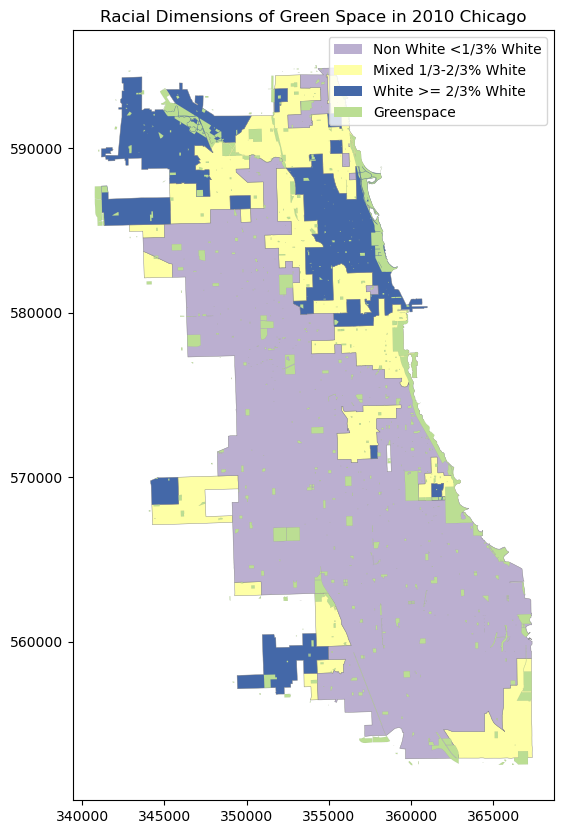

<Figure size 640x480 with 0 Axes>

In [553]:
# dissolve the tracts geometry by racial majority group
greenaccesstracts = greenaccesstracts.dissolve(by= 'Segregated')
greenaccesstracts['Segregated'] = greenaccesstracts.index

# Set up the base plot
fig, ax = plt.subplots(figsize=(10, 10))

# Define a function to assign colors based on 'majorGroup' column
def assign_color(feature):
    major_group = feature['Segregated']
    if major_group == 'NonWhite':
        return '#bbafd0FF'
    elif major_group == 'Mixed':
        return '#feffa6FF'
    elif major_group == 'White':
        return '#4468a8FF'
    else:
        return '#ffff00'

# Plot greenaccesstracts with different colors based on 'majorGroup' column
greenaccesstracts.plot(ax=ax, color=greenaccesstracts.apply(assign_color, axis=1), edgecolor='grey', linewidth=0.3)

# Plot greenspace 
greenspace.plot(ax=ax, color='#bbde93', edgecolor='grey', linewidth=0.05, alpha=1)

# Customize legend based on the colors for each majority group
plt.title('Racial Dimensions of Green Space in 2010 Chicago')
legend_patches = [
    Patch(facecolor='#bbafd0FF', label='Non White <1/3% White'),
    Patch(facecolor='#feffa6FF', label='Mixed 1/3-2/3% White'),
    Patch(facecolor='#4468a8FF', label='White >= 2/3% White'),
    Patch(facecolor='#bbde93', label='Greenspace')
]

# Add legend with the created patches
plt.legend(handles=legend_patches)

# Show the plot
plt.show()

plt.savefig( here(path["rfig"], 'fig2.png') ) # Save image